# Data import 


In [11]:
import pandas as pd
# import of data
student_data_unpr = pd.read_excel("../data/subset_studium_german.xlsx")
student_data_unpr = student_data_unpr[student_data_unpr["Studium_Label"].notnull()]
student_data_unpr = student_data_unpr.drop("Unnamed: 0", axis=1)
student_data_unpr = student_data_unpr.drop("Studium_Comment", axis=1)

#Reduction to 103 entries
student_data_unpr = student_data_unpr.drop(student_data_unpr.index[303:], axis=0)

#Creation of a copy and reduction to column "Studium"
student_data = student_data_unpr
student_data = student_data.drop("Studium_Label", axis=1)




Anzahl der Zeilen: 303
303


TypeError: 'target_names' is an invalid keyword argument for print()

# OpenAI GPT3.5 application

In [2]:
from openai import OpenAI
client = OpenAI()



In [4]:
#Prompt for GPT
initial_message = {"role": "user", "content": "You are my sentiment assistant. I want you to analyze my text and categorize it into the three sentiments: positive, neutral, negative. Only response with either positive, neutral or negative"}

results=[]
results_df = []

# Sending labeling requests to GPT
for index, eintrag in student_data.iterrows():
    for inhalt in eintrag:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                initial_message,
                {"role": "user", "content": inhalt}
            ],
            temperature=0,
        )
        
        # Saving of responses 
        results.append({"index": index, "sentimentPrediction": response.choices[0].message.content})

# Conversion of responses into dataframe
results_df = pd.DataFrame(results)




In [5]:
display(results_df)

,index,sentimentPrediction
0,0,neutral
1,1,positive
2,2,neutral
3,3,positive
4,4,positive
...,...,...
298,300,neutral
299,301,positive
300,302,positive
301,303,neutral


# Evaluation

In [30]:
#Merge target labels with predicted labels
results_df = results_df.drop("index", axis=1)
student_data = pd.concat([student_data_unpr, results_df], axis=1)

#Convertion of all values into strings
for x in student_data:
    student_data[x] = student_data[x].astype(str)

#Deletion of all unwanted values in "Studium_Label" and "sentimentPrediction"
allowed_values=["negative", "neutral", "positive"]    
student_data = student_data[student_data['Studium_Label'].isin(allowed_values)]
student_data = student_data[student_data['sentimentPrediction'].isin(allowed_values)]

display(student_data)
    


,Studium,Studium_Label,sentimentPrediction
0,Die Vorlesungszeit war von Anfang September bi...,neutral,neutral
1,Die Pazmany Universität ist sehr klein im Verg...,positive,positive
2,Mit der Universität selbst hatten wir wenig zu...,neutral,neutral
3,Da die Vorlesungen wegen der Pandemie online s...,positive,positive
4,Die City University of Hong Kong hat eine groß...,negative,positive
...,...,...,...
298,Die Cardiff University sieht sich selbst als r...,positive,neutral
299,Die Kurse können je nach Wahl natürlich mal me...,neutral,positive
300,"Ich entschied mich, alle Kurse auf Spanisch zu...",neutral,positive
301,Die Studienzeiten in England unterscheiden sic...,neutral,neutral


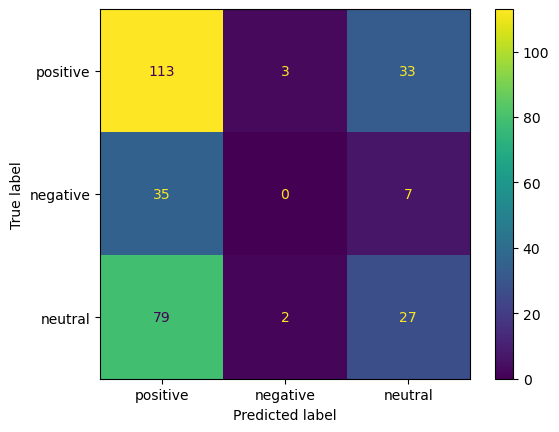

0.4682274247491639
              precision    recall  f1-score   support

    positive       0.00      0.00      0.00        42
    negative       0.40      0.25      0.31       108
     neutral       0.50      0.76      0.60       149

    accuracy                           0.47       299
   macro avg       0.30      0.34      0.30       299
weighted avg       0.39      0.47      0.41       299



In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt

#Creation of confusion matrix
confusion_mat = confusion_matrix(student_data['Studium_Label'], student_data['sentimentPrediction'], labels=['positive', 'negative', 'neutral'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()

#Accuracy
print(f1_score(student_data['Studium_Label'], student_data['sentimentPrediction'], labels=['positive', 'negative', 'neutral'], average='micro'))

#Creation of presicion, recall, F1 and support
print(classification_report(
    student_data['Studium_Label'],
    student_data['sentimentPrediction'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))